<a href="https://colab.research.google.com/github/Tstrebe2/ml-mastery-transformers/blob/main/chapter-7/exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7.1 Keras SimpleRNN Layer

In [36]:
import math
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps × features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are
discussed below.

In [2]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(SimpleRNN(hidden_units, input_shape=input_shape,
    activation=activation[0]))
  model.add(Dense(units=dense_units, activation=activation[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

demo_model = create_RNN(2, 1, (3, 1), activation=['linear', 'linear'])

The object demo_model is returned with two hidden units created via the SimpleRNN layer and one dense unit created via the Dense layer. The input_shape is set at 3 × 1, and a linear activation function is used in both layers for simplicity. Just to recall, the linear activation function $f(x) = x$ makes no change in the input. If we have m hidden units ($m = 2$ in the code above), then the network looks as follows:  
⊲ Input: x ∈ R  
⊲ Hidden unit: h ∈ Rm  
⊲ Weights for the input units: wx ∈ Rm  
⊲ Weights for the hidden units: wh ∈ Rm×m  
⊲ Bias for hidden units: bh ∈ Rm  
⊲ Weight for the dense layer: wy ∈ Rm  
⊲ Bias for the dense layer: by ∈ R  
Let’s look at the above weights.

In [3]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]

Now let’s do a simple experiment to see how the layers from a **SimpleRNN** and **Dense layer** produce an output. Keep this figure in view.

In [4]:
print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-1.2208681   0.45507872]]  wh =  [[ 0.7013521  0.712815 ]
 [-0.712815   0.7013521]]  bh =  [0. 0.]  wy = [[0.43517363]
 [1.0805475 ]] by =  [0.]


We’ll input $x$ for three time steps and let the network generate an output. The values of the hidden units at time steps 1, 2, and 3 will be computed. $h0$ is initialized to the zero vector. The output $o3$ is computed from $h3$ and $wy$. An activation function is not required as we are
using linear units.

Now let’s do a simple experiment to see how the layers from a **SimpleRNN** and **Dense layer** produce an output. Keep this figure in view.

In [5]:
x = np.array([1, 2, 3])
x_input = x.reshape((1, 3, 1))

y_pred_model = demo_model.predict(x_input)

m = 2
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1, wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2, wh) + bh
o3 = np.dot(h3, wy) + by

print('h1 =', h1, 'h2 =', h2, 'h3 =', h3)
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

1/1 [==============================] - 1s 519ms/step
h1 = [[-1.22086811  0.45507872]] h2 = [[-3.62238159  0.35907478]] h3 = [[-6.45912322 -0.96501386]]
Prediction from network  [[-3.8535838]]
Prediction from our computation  [[-3.85358338]]


## 7.2 Running the RNN on Sunspots Dataset

Now that we understand how the SimpleRNN and Dense layers are put together. Let’s run a complete RNN on a simple time series dataset. We’ll need to follow these steps:
1. Read the dataset from a given URL
2. Split the data into training and test set
3. Prepare the input to the required Keras format
4. Create an RNN model and train it
5. Make the predictions on training and test sets and print the root mean square error on both sets
6. View the result  

#### Step 1, 2: Reading Data and Splitting into Training and Test. 
The following function reads the train and test data from a given URL and splits it into a given percentage of train and test data. It returns single-dimensional arrays for train and test data after scaling the data between 0 and 1 using MinMaxScaler from scikit-learn


In [9]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
  df = read_csv(url, usecols=[1], engine='python')
  data = np.array(df.values.astype('float32'))
  scaler = MinMaxScaler(feature_range=(0, 1))
  data = scaler.fit_transform(data).flatten()
  n = len(data)
  # Point for splitting data into train and test
  split = int(n*split_percent)
  train_data = data[range(split)]
  test_data = data[split:]
  return train_data, test_data, data

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv"
train_data, test_data, data = get_train_test(url)

#### Step 3: Reshaping Data For Keras
The next step is to prepare the data for Keras model training. The input array should be shaped as: (total_samples, time_steps, features).
There are many ways of preparing time series data for training. We’ll create input rows with non-overlapping time steps. An example for time_steps=2 is shown in the figure below. Here, time_steps denotes the number of previous time steps to use for predicting the next value of the time series data.

The following function ```get_XY()``` takes a one-dimensional array as input and converts it to the required input $\vec{X}$ and target $\vec{Y}$ arrays. We’ll use time_steps=12 for the sunspots dataset as the sunspots generally have a cycle of 12 months. You can experiment with other values of time_steps.

In [31]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
  # Indices of target array
  Y_ind = np.arange(time_steps, len(dat), time_steps)
  Y = dat[Y_ind]
  # Prepare X
  rows_x = len(Y)
  X = dat[range(time_steps*rows_x)]
  X = np.reshape(X, (rows_x, time_steps, 1))
  return X, Y

time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

#### Step 4: Create RNN Model and Train
For this step, you can reuse your create_RNN() function that was defined above.

In [32]:
model = create_RNN(hidden_units=3, 
                   dense_units=1, 
                   input_shape=(time_steps, 1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 1s - loss: 0.0078 - 1s/epoch - 6ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0064 - 340ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0057 - 345ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0052 - 351ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0049 - 353ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0047 - 335ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0045 - 360ms/epoch - 2ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0044 - 338ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0043 - 325ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0041 - 338ms/epoch - 2ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0041 - 353ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0040 - 338ms/epoch - 2ms/step
Epoch 13/20
187/187 - 0s - loss: 0.0039 - 339ms/epoch - 2ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0039 - 357ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0038 - 358ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

#### Step 5: Compute and Print the Root Mean Square Error
The function ```print_error()``` computes the mean square error between the actual and predicted values.

In [33]:
def print_error(trainY, testY, train_predict, test_predict):
  # Error of predictions
  train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
  test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
  # Print RMSE
  print('Train RMSE: %.3f RMSE' % (train_rmse))
  print('Test RMSE: %.3f RMSE' % (test_rmse))
  
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 5ms/step
Train RMSE: 0.060 RMSE
Test RMSE: 0.093 RMSE


#### Step 6: View the Result
The following function plots the actual target values and the predicted values. The red line separates the training and test data points.

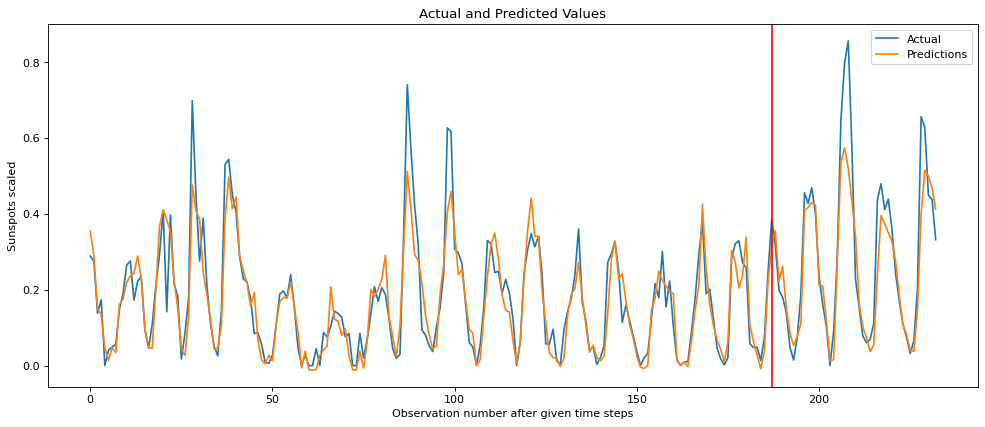

In [37]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
  actual = np.append(trainY, testY)
  predictions = np.append(train_predict, test_predict)
  rows = len(actual)
  plt.figure(figsize=(15, 6), dpi=80)
  plt.plot(range(rows), actual)
  plt.plot(range(rows), predictions)
  plt.axvline(x=len(trainY), color='r')
  plt.legend(['Actual', 'Predictions'])
  plt.xlabel('Observation number after given time steps')
  plt.ylabel('Sunspots scaled')
  plt.title('Actual and Predicted Values')
  
plot_result(trainY, testY, train_predict, test_predict)